<a href="https://colab.research.google.com/github/mohadesehsotoudehnia/FIS-projects/blob/main/Part1_FinalProject%20/%20Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install gdown

In [ ]:
import gdown


file_id = "1rQbfW2vL5jk8UrZQlnxrstwMAmKWawAg"

url = f"https://drive.google.com/uc?id={file_id}"
output = "Loan_Dataset.zip"

gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1rQbfW2vL5jk8UrZQlnxrstwMAmKWawAg
To: /content/Loan_Dataset.zip
100%|██████████| 11.2k/11.2k [00:00<00:00, 18.0MB/s]


'Loan_Dataset.zip'

In [ ]:
import zipfile
import os

extract_dir = "loan_data"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile("Loan_Dataset.zip", "r") as zip_ref:
    zip_ref.extractall(extract_dir)

os.listdir(extract_dir)


['loan_train.csv', 'loan_test.csv']

In [ ]:
import pandas as pd

train_df = pd.read_csv("loan_data/loan_train.csv")
test_df  = pd.read_csv("loan_data/loan_test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()


Train shape: (614, 12)
Test shape: (367, 11)


,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


In [ ]:
before_rows = train_df.shape[0]

train_df = train_df.dropna()

after_rows = train_df.shape[0]

print("Rows before removing NaN:", before_rows)
print("Rows after removing NaN:", after_rows)
print("Removed rows:", before_rows - after_rows)


Rows before removing NaN: 614
Rows after removing NaN: 499
Removed rows: 115


In [ ]:
train_df.isna().sum()


,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
Applicant_Income,0
Coapplicant_Income,0
Loan_Amount,0
Term,0
Credit_History,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

train_df.columns = train_df.columns.str.strip()

categorical_cols = [
    "Gender",
    "Married",
    "Dependents",
    "Education",
    "Self_Employed",
    "Area",
    "Status"
]

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])

train_df.head()


,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,1,0,0,0,0,584900,0.0,15000000,360.0,1.0,2,1
1,1,1,1,0,0,458300,150800.0,12800000,360.0,1.0,0,0
2,1,1,0,0,1,300000,0.0,6600000,360.0,1.0,2,1
3,1,1,0,1,0,258300,235800.0,12000000,360.0,1.0,2,1
4,1,0,0,0,0,600000,0.0,14100000,360.0,1.0,2,1


In [ ]:
train_df.dtypes


,0
Gender,int64
Married,int64
Dependents,int64
Education,int64
Self_Employed,int64
Applicant_Income,int64
Coapplicant_Income,float64
Loan_Amount,int64
Term,float64
Credit_History,float64


In [ ]:
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=["Status"])
y = train_df["Status"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (349, 11)
X_test shape: (150, 11)
y_train shape: (349,)
y_test shape: (150,)


In [ ]:
!pip -q install pyswarms


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pyswarms as ps
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [ ]:
X_train_np = X_train.to_numpy()
X_test_np  = X_test.to_numpy()

feature_names = X_train.columns.to_numpy()
n_features = X_train_np.shape[1]


In [ ]:
def fitness_function(particles, X_train_np, X_test_np, y_train, y_test, alpha=0.9):
    n_particles, n_features = particles.shape
    fitness = np.zeros(n_particles)

    for i in range(n_particles):
        mask = particles[i] > 0.5
        k = mask.sum()

        if k == 0:
            fitness[i] = 1.0
            continue

        X_tr = X_train_np[:, mask]
        X_te = X_test_np[:, mask]

        model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_tr, y_train)

        acc = accuracy_score(y_test, model.predict(X_te))

        fitness[i] = alpha * (1 - acc) + (1 - alpha) * (1 - (k / n_features))

    return fitness


In [ ]:
options = {'c1': 1, 'c2': 2, 'w': 0.9}
n_particles = 50
iterations = 100
dimensions = n_features

optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particles,
    dimensions=dimensions,
    options=options
)


In [ ]:
best_cost, best_position = optimizer.optimize(
    fitness_function,
    iters=iterations,
    X_train_np=X_train_np,
    X_test_np=X_test_np,
    y_train=y_train,
    y_test=y_test,
    alpha=0.9
)


2026-02-08 23:06:45,096 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1, 'c2': 2, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.171
2026-02-08 23:28:16,186 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.17109090909090915, best pos: [ 0.70656346  2.07228626  1.87753698  1.35923936  3.564377    1.62636195
  1.46792342 -0.60212831  1.39857633  1.78077867  1.61335479]


In [ ]:
selected_mask = best_position > 0.5
selected_feature_names = feature_names[selected_mask]

print("Selected features:", selected_feature_names.tolist())
print("Number of selected features:", int(selected_mask.sum()))
print("Best fitness value:", best_cost)


Selected features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Term', 'Credit_History', 'Area']
Number of selected features: 10
Best fitness value: 0.17109090909090915


In [ ]:
final_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_np[:, selected_mask], y_train)
final_pred = final_model.predict(X_test_np[:, selected_mask])

final_accuracy = accuracy_score(y_test, final_pred)
print("Final accuracy (PSO):", final_accuracy)


Final accuracy (PSO): 0.82


In [ ]:
pso_best_cost_history = optimizer.cost_history


In [ ]:
!pip -q install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 4.8 MB/s eta 0:00:00


In [ ]:
import random
import numpy as np

from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [ ]:
X_train_np = X_train.to_numpy()
X_test_np  = X_test.to_numpy()
y_train_np = np.array(y_train)
y_test_np  = np.array(y_test)

feature_names = X_train.columns.to_numpy()
n_features = X_train_np.shape[1]


In [ ]:
POP_SIZE = 50
N_GEN = 50
CXPB = 0.9
MUTPB = 0.1
ALPHA = 0.9


In [ ]:
if "FitnessMin" not in creator.__dict__:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_bit", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bit, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [ ]:
def eval_individual(individual):
    mask = np.array(individual, dtype=bool)
    k = int(mask.sum())

    if k == 0:
        return (1.0,)

    X_tr = X_train_np[:, mask]
    X_te = X_test_np[:, mask]

    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_tr, y_train_np)

    acc = accuracy_score(y_test_np, model.predict(X_te))


    J = ALPHA * (1 - acc) + (1 - ALPHA) * (1 - (k / n_features))
    return (J,)



In [ ]:
toolbox.register("evaluate", eval_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


In [ ]:
random.seed(42)

pop = toolbox.population(n=POP_SIZE)

invalid_ind = [ind for ind in pop if not ind.fitness.valid]
fitnesses = list(map(toolbox.evaluate, invalid_ind))
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

ga_best_fitness_history = []

for gen in range(1, N_GEN + 1):
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for c1, c2 in zip(offspring[0::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(c1, c2)
            del c1.fitness.values
            del c2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = list(map(toolbox.evaluate, invalid_ind))
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop[:] = offspring

    best = tools.selBest(pop, 1)[0]
    ga_best_fitness_history.append(best.fitness.values[0])

    print(f"Gen {gen:02d} | Best J: {best.fitness.values[0]:.6f} | Selected: {int(np.sum(best))}")



Gen 01 | Best J: 0.198182 | Selected: 9
Gen 02 | Best J: 0.180182 | Selected: 9
Gen 03 | Best J: 0.183091 | Selected: 10
Gen 04 | Best J: 0.171091 | Selected: 10
Gen 05 | Best J: 0.171091 | Selected: 10
Gen 06 | Best J: 0.171091 | Selected: 10
Gen 07 | Best J: 0.171091 | Selected: 10
Gen 08 | Best J: 0.171091 | Selected: 10
Gen 09 | Best J: 0.171091 | Selected: 10
Gen 10 | Best J: 0.171091 | Selected: 10
Gen 11 | Best J: 0.171091 | Selected: 10
Gen 12 | Best J: 0.171091 | Selected: 10
Gen 13 | Best J: 0.171091 | Selected: 10
Gen 14 | Best J: 0.171091 | Selected: 10
Gen 15 | Best J: 0.171091 | Selected: 10
Gen 16 | Best J: 0.171091 | Selected: 10
Gen 17 | Best J: 0.171091 | Selected: 10
Gen 18 | Best J: 0.171091 | Selected: 10
Gen 19 | Best J: 0.171091 | Selected: 10
Gen 20 | Best J: 0.171091 | Selected: 10
Gen 21 | Best J: 0.171091 | Selected: 10
Gen 22 | Best J: 0.171091 | Selected: 10
Gen 23 | Best J: 0.171091 | Selected: 10
Gen 24 | Best J: 0.171091 | Selected: 10
Gen 25 | Best J: 0

In [ ]:
best_ind = tools.selBest(pop, 1)[0]
best_mask = np.array(best_ind, dtype=bool)

selected_features_ga = feature_names[best_mask]
print("Selected features (GA):", selected_features_ga.tolist())
print("Number of selected features (GA):", int(best_mask.sum()))
print("Best fitness value J (GA):", best_ind.fitness.values[0])


Selected features (GA): ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Term', 'Credit_History', 'Area']
Number of selected features (GA): 10
Best fitness value J (GA): 0.17109090909090915


In [ ]:
final_model_ga = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

final_model_ga.fit(X_train_np[:, best_mask], y_train_np)
ga_acc = accuracy_score(y_test_np, final_model_ga.predict(X_test_np[:, best_mask]))

print("Final accuracy (GA):", ga_acc)


Final accuracy (GA): 0.82


In [ ]:
selected_features_pso = X_train.columns[selected_mask]
print("PSO selected features:")
print(selected_features_pso.tolist())


selected_features_ga = X_train.columns[best_mask]
print("\nGA selected features:")
print(selected_features_ga.tolist())


PSO selected features:
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Term', 'Credit_History', 'Area']

GA selected features:
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Term', 'Credit_History', 'Area']


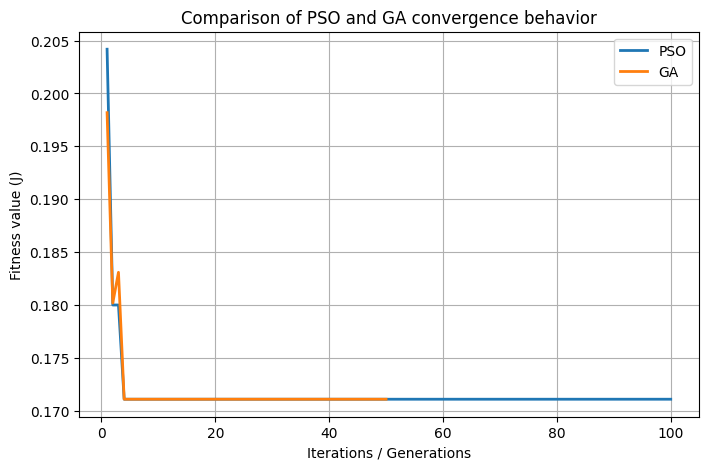

In [ ]:
import matplotlib.pyplot as plt

pso_iters = range(1, len(pso_best_cost_history) + 1)
ga_gens = range(1, len(ga_best_fitness_history) + 1)

plt.figure(figsize=(8, 5))

plt.plot(pso_iters, pso_best_cost_history, label='PSO', linewidth=2)

plt.plot(ga_gens, ga_best_fitness_history, label='GA', linewidth=2)

plt.xlabel('Iterations / Generations')
plt.ylabel('Fitness value (J)')
plt.title('Comparison of PSO and GA convergence behavior')
plt.legend()
plt.grid(True)

plt.show()
